# ALS project

## EDA

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from pandas_profiling import ProfileReport
import webbrowser, os

In [7]:
import pickle
import h5py
import string
import math

In [8]:
def feature_report(df):
    '''
    print a report of every feature
    '''
    profile = ProfileReport(df, bins=30)
    profile.to_file(outputfile="output.html")
    webbrowser.open('file://' + os.path.realpath("output.html"))
    #end function

In [9]:
def dups(df):
    '''
    finds duplicated values in dataframe, requires 'subject_id'
    '''
    bill = df.copy()
    dup_cols = []
    bill['test_dup']= np.ones(len(df))
    g = bill.groupby('subject_id').count()
    print("Length df: {}".format(len(df)))
    print("Length g: {}".format(len(g)))
    for c in range(len(g.columns)):
        mask = (g.iloc[:,c]>1)
        dup_cols.append(sum(mask))
    print("Number subjects duplicated: {}".format(np.max(dup_cols)))
    bill.drop('test_dup', axis=1, inplace=True)
    if np.max(dup_cols)>=1:
        return g[mask]

In [10]:
def to_zero_one(df, col_list):
    '''
    convert nans to 0
    input:
        df = dataframe
        col_list = list of columns to apply the change
    '''
    for col in col_list:
        df[col].fillna(int(0), inplace=True)

In [11]:
def ints(df, col_list):
    '''
    makes column integer values
    input:
        df = dataframe
        col_list = list of columns to apply the change
    '''
    for col in col_list:
        df[col] = df[col].astype(int)

## treatment arms  
- single entry per subject
- 'placebo' =  only placebo subjects (n=2912)

In [742]:
txt = pd.read_csv("data/Treatment.csv")

In [743]:
txt.head()

,subject_id,Study_Arm,Treatment_Group_Delta
0,89,Active,NaN
1,329,Active,0.0
2,348,Placebo,0.0
3,406,Active,NaN
4,411,Active,NaN


In [744]:
# look for duplicted subjects in the dataset
print(len(txt))  # 9640
print(len(set(txt['subject_id'])))  #9640 = all unique subjects

9640
9640


In [745]:
dups(txt)

Length df: 9640
Length g: 9640
Number subjects duplicated: 0


In [746]:
#feature_report(txt)
# placebo = 30.2% of subjects
# active = 69.8% of subjects

In [747]:
# remove the Treatment_Group_Delta column.
txt.drop('Treatment_Group_Delta', axis=1, inplace=True)

In [748]:
# id's of placebo subjects
placebo = txt.loc[txt['Study_Arm']=='Placebo']
print(len(placebo))
placebo.head()

2912


,subject_id,Study_Arm
2,348,Placebo
7,902,Placebo
9,1064,Placebo
11,1312,Placebo
16,2132,Placebo


In [749]:
filename = 'clean_data/txt.csv'
txt.to_csv(filename, index=False)

## Riluzole  
shape: 1 entry per subject (not all subjects)

In [17]:
riluzole = pd.read_csv("data/Riluzole.csv")

In [18]:
print(riluzole.shape)
riluzole.head()

(8817, 3)


,subject_id,Subject_used_Riluzole,Riluzole_use_Delta
0,89,Yes,0.0
1,348,Yes,0.0
2,406,Yes,0.0
3,411,Yes,0.0
4,586,No,0.0


In [19]:
dups(riluzole)

Length df: 8817
Length g: 8817
Number subjects duplicated: 0


In [20]:
riluzole.drop('Riluzole_use_Delta', axis=1, inplace=True)

In [21]:
# convert riluzole usage to 1=yes, 0=no
riluzole['Subject_used_Riluzole'].replace({'Yes': int(1), 'No': int(0)}, inplace=True)

In [22]:
riluzole.head()

,subject_id,Subject_used_Riluzole
0,89,1
1,348,1
2,406,1
3,411,1
4,586,0


In [23]:
# save the clean file
filename = 'clean_data/riluzole.csv'
riluzole.to_csv(filename, index=False)

## Demographic
- single entry

In [47]:
demo=pd.read_csv("data/demographics.csv")

In [48]:
print(demo.shape)
demo.head()

(10723, 14)


,subject_id,Demographics_Delta,Age,Date_of_Birth,Ethnicity,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,Sex
0,89,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
1,329,0.0,38.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Female
2,348,0.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Female
3,406,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
4,411,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male


In [49]:
dups(demo)

Length df: 10723
Length g: 10723
Number subjects duplicated: 0


In [50]:
# remove 'Demographics_Delta' data
demo.drop('Demographics_Delta', axis=1, inplace=True)

In [51]:
# make Male=1, Female=0
demo['sex'] = demo['Sex'].replace({'Male': int(1), 'Female': int(0)})
demo.drop('Sex', axis=1, inplace=True)

In [52]:
# 'age' is age at trial start
demo['age_trial_start_years'] = demo['Age']

In [53]:
demo['age_trial_start_days'] = demo['Age']*365

In [54]:
# drop date of birth - sparce and not relavent
demo.drop('Date_of_Birth', axis=1, inplace=True)

In [55]:
# replace most columns with NaNs as 0
cols=[ 'Race_Americ_Indian_Alaska_Native','Race_Asian','Race_Black_African_American',
      'Race_Hawaiian_Pacific_Islander','Race_Caucasian','Race_Other']
to_zero_one(df=demo, col_list=cols)
ints(df=demo, col_list=cols)

In [56]:
demo['sex'].unique()

array([ 1.,  0., nan])

In [57]:
demo.head()

,subject_id,Age,Ethnicity,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days
0,89,NaN,NaN,0,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
1,329,38.0,NaN,0,0,1,0,NaN,0,0,NaN,0.0,38.0,13870.0
2,348,52.0,NaN,0,0,0,0,NaN,1,0,NaN,0.0,52.0,18980.0
3,406,NaN,NaN,0,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
4,411,NaN,NaN,0,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN


In [58]:
# save the clean file
filename = 'clean_data/demo.csv'
demo.to_csv(filename, index=False)

## Labs  
- multi-subject
- make this tidy

In [35]:
labs = pd.read_csv("data/Labs.csv")

In [36]:
labs.head()

,subject_id,Test_Name,Test_Result,Test_Unit,Laboratory_Delta
0,329,Hemoglobin,130,g/L,0.0
1,329,Urine Color,YELLOW,NaN,0.0
2,329,Uric Acid,237.92,umol/L,0.0
3,329,ALPHA2-GLOBULIN,1,g/dL,0.0
4,329,Sodium,138,mmol/L,0.0


In [37]:
labs['study_day'] = labs["Laboratory_Delta"]
labs.drop("Laboratory_Delta", axis=1, inplace=True)

In [38]:
# only use lab data from placebo subjects to cut down on size
placebo_labs = labs.merge(placebo, how='inner', on='subject_id')

In [39]:
placebo_labs.head()

,subject_id,Test_Name,Test_Result,Test_Unit,study_day,Study_Arm
0,348,Bicarbonate,25.5,mmol/L,0.0,Placebo
1,348,Basophils,.6,%,0.0,Placebo
2,348,Bilirubin (Direct),1.71,umol/L,0.0,Placebo
3,348,Triglycerides,1.1516,mmol/L,0.0,Placebo
4,348,Urine Urobilinogen,Normal,NONE,0.0,Placebo


In [42]:
placebo_labs.shape

(945726, 6)

In [43]:
# don't run this unless you have to!!
#labs.pivot(columns='Test_Name', values=['Test_Result','Test_Unit'])

In [ ]:
labs.head()

## Functional responses from one subject

In [81]:
# plot one subject's questionaire scores.
# subject # 348
s348 = question[ question['subject_id']==348]

In [82]:
s348.head()

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day
12,348,4.0,4.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,1.0,NaN,NaN,39.0,4.0,4.0,4.0,0.0
13,348,4.0,4.0,4.0,3.0,2.0,NaN,2.0,4.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,4.0
14,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,52.0
15,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,61.0
16,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,99.0


In [83]:
Qs=list(s348.columns)
print(Qs)

['subject_id', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy', 'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 'Q10_Respiratory', 'ALSFRS_Total', 'ALSFRS_R_Total', 'R_1_Dyspnea', 'R_2_Orthopnea', 'R_3_Respiratory_Insufficiency', 'study_day']


## Merge single-entry tables

#### txt, death

In [63]:
death = pd.read_csv("clean_data/death.csv")

In [64]:
txt = pd.read_csv("clean_data/txt.csv")

In [65]:
# merge treatement data with death data
txt_d = txt.merge(death, how='left', on='subject_id')

In [66]:
print(txt_d.shape)
txt_d.head(10)

(9640, 4)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start
0,89,Active,1.0,218.0
1,329,Active,NaN,NaN
2,348,Placebo,NaN,NaN
3,406,Active,NaN,NaN
4,411,Active,1.0,141.0
5,649,Active,NaN,NaN
6,708,Active,1.0,250.0
7,902,Placebo,0.0,NaN
8,1025,Active,NaN,NaN
9,1064,Placebo,NaN,NaN


In [67]:
# number of placebo who died = 1088
# number of subjects who did not die = 447
# number of subjects with NaN = 1377
len(txt_d[ (txt_d['Subject_Died']==1) & (txt_d['Study_Arm']=='Placebo')])

1088

#### txt, death, riluzole

In [68]:
riluzole = pd.read_csv("clean_data/riluzole.csv")

In [69]:
# merge df with riluzole
tdr = txt_d.merge(riluzole, how='left', on='subject_id')

In [70]:
print(tdr.shape)
tdr.head()

(9640, 5)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole
0,89,Active,1.0,218.0,1.0
1,329,Active,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0
3,406,Active,NaN,NaN,1.0
4,411,Active,1.0,141.0,1.0


#### tx, death, riluzole, onset dates

In [78]:
onset = pd.read_csv("clean_data/onset_date.csv")

In [79]:
tdro = tdr.merge(onset, how='left', on='subject_id')

In [80]:
print(tdro.shape)
tdro.head(10)

(9640, 8)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN
5,649,Active,NaN,NaN,1.0,-341.0,NaN,NaN
6,708,Active,1.0,250.0,NaN,-1070.0,-986.0,84.0
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0,465.0
8,1025,Active,NaN,NaN,1.0,NaN,NaN,NaN
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0,88.0


In [81]:
tdro['death_day_since_onset'] = np.abs(tdro['Onset_Delta']) + tdro['death_days_trail_start']
print(tdro.shape)
tdro.head(10)

(9640, 9)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN
5,649,Active,NaN,NaN,1.0,-341.0,NaN,NaN,NaN
6,708,Active,1.0,250.0,NaN,-1070.0,-986.0,84.0,1320.0
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0,465.0,NaN
8,1025,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0,88.0,NaN


In [82]:
# mean death days since onset
death_day_mean = tdro['death_day_since_onset'].mean()
death_day_stdev = tdro['death_day_since_onset'].std()
print(death_day_mean)
print(death_day_stdev)

In [84]:
# add differnce from mean death days to dataset
death_day_mean = tdro['death_day_since_onset'].mean()
tdro['death_day_mean_delta'] = death_day_mean - tdro['death_day_since_onset']
#tdro['death_day_stdev'] = death_day_stdev

In [85]:
print(tdro.shape)
tdro.head(10)

(9640, 10)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN
5,649,Active,NaN,NaN,1.0,-341.0,NaN,NaN,NaN,NaN
6,708,Active,1.0,250.0,NaN,-1070.0,-986.0,84.0,1320.0,-361.814073
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0,465.0,NaN,NaN
8,1025,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0,88.0,NaN,NaN


In [86]:
# number of subjects that died after disease onset, placebo
len( tdro[ (tdro['death_day_since_onset']>0) & (tdro['Study_Arm']=='Placebo')])

738

In [87]:
# number of subjects that died after disease onset, active
len( tdro[ (tdro['death_day_since_onset']>0) & (tdro['Study_Arm']=='Active')])

1010

In [88]:
placebo = tdro[ tdro['Study_Arm']=='Placebo']
print(placebo.shape)
placebo.head()

(2912, 10)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0,465.0,NaN,NaN
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0,88.0,NaN,NaN
11,1312,Placebo,0.0,NaN,0.0,-247.0,-63.0,184.0,NaN,NaN
16,2132,Placebo,1.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN


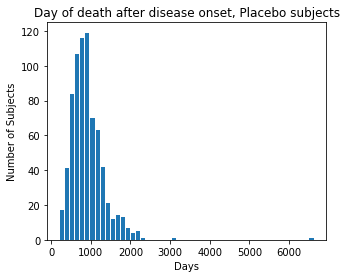

In [89]:
plt.figure(figsize=(5,4))
plt.hist(placebo['death_day_since_onset'], bins=50, rwidth=0.8)
plt.title("Day of death after disease onset, Placebo subjects")
plt.xlabel("Days")
plt.ylabel("Number of Subjects")
plt.show()

In [90]:
active = tdro[ tdro['Study_Arm']=='Active']
print(active.shape)
active.head()

(6728, 10)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN
5,649,Active,NaN,NaN,1.0,-341.0,NaN,NaN,NaN,NaN


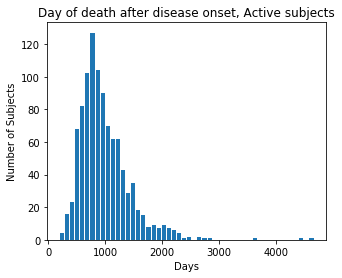

In [91]:
plt.figure(figsize=(5,4))
plt.hist(active['death_day_since_onset'], bins=50, rwidth=0.8)
plt.title("Day of death after disease onset, Active subjects")
plt.xlabel("Days")
plt.ylabel("Number of Subjects")
plt.show()

In [92]:
# add death windows
tdro['death_week'] = (tdro['death_day_since_onset']/7).apply(np.floor)

In [93]:
tdro['death_month'] = (tdro['death_day_since_onset']/30).apply(np.floor)

In [94]:
tdro.head(20)

,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,death_month
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,649,Active,NaN,NaN,1.0,-341.0,NaN,NaN,NaN,NaN,NaN,NaN
6,708,Active,1.0,250.0,NaN,-1070.0,-986.0,84.0,1320.0,-361.814073,188.0,44.0
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0,465.0,NaN,NaN,NaN,NaN
8,1025,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0,88.0,NaN,NaN,NaN,NaN


#### txt, death, riluzole, onset dates, demo

In [95]:
demo = pd.read_csv("clean_data/demo.csv")

In [96]:
tdrod = tdro.merge(demo, how='left', on='subject_id')

In [97]:
print(tdrod.shape)
tdrod.head()

(9640, 25)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,...,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,...,0,1,0,NaN,0,0,NaN,0.0,38.0,13870.0
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,...,0,0,0,NaN,1,0,NaN,0.0,52.0,18980.0
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN


In [98]:
# save version as csv
filename = 'clean_data/tdrod.csv'
tdrod.to_csv(filename, index=False)

## Functional Responses from Placebo subjects only

In [ ]:
# combine subjects with at least one questionaire
p = placebo.drop('Treatment_Group_Delta', axis=1)
p_qs = question.merge(p, how='inner', on='subject_id')

In [68]:
p_qs.head()

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Study_Arm
0,348,4.0,4.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,1.0,NaN,NaN,39.0,4.0,4.0,4.0,0.0,Placebo
1,348,4.0,4.0,4.0,3.0,2.0,NaN,2.0,4.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,4.0,Placebo
2,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,52.0,Placebo
3,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,61.0,Placebo
4,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,99.0,Placebo


In [69]:
# number questionaires per placebo subject
grp_p_qs = p_qs.groupby('subject_id')
n_p_qs = grp_p_qs['subject_id'].count()

In [70]:
n_p_qs.head()

subject_id
348     15
902      7
1064    16
1312     1
2540     4
Name: subject_id, dtype: int64

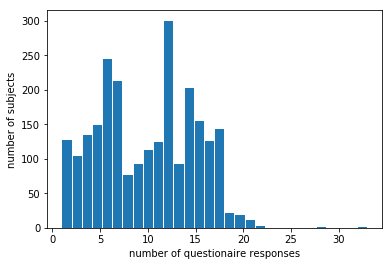

In [71]:
# how many visits per subject?
plt.hist(n_p_qs, rwidth=0.9, bins=30)
plt.xlabel("number of questionaire responses")
plt.ylabel("number of subjects")
plt.show()

### Plot stats

In [156]:
# plot question decline
def plot_question(df):
    '''
    plot the total functional test questionaire data
    input:
        df = pandas dataframe
        revised = 'R' or 'O', revised or original
    output:
        single plot
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))
    subjects = df['subject_id'].unique()
    for subject in subjects:
        sub = df[ df['subject_id'] == subject]
        if np.any(sub['Subject_Died']=='Yes'):
            color = 'red'
        else:
            color = 'gray'
        if np.max(sub['days_since_onset']) > 4000:
            continue
        if np.all(sub['ALSFRS_R_Total'].isnull()):
            ax1.plot(sub['days_since_onset'], sub['ALSFRS_Total'], color=color,
                     alpha=0.5, linewidth=1)
        else:
            ax2.plot(sub['days_since_onset'], sub['ALSFRS_R_Total'], color=color,
                     alpha=0.5, linewidth=1)
    ax1.set_title('Original Function Assess')
    ax2.set_title('Revised Function Assess')
    plt.ylim(bottom=0, top=50)
    plt.xlim(left=0, right=4000)
    plt.tight_layout()
    plt.show()

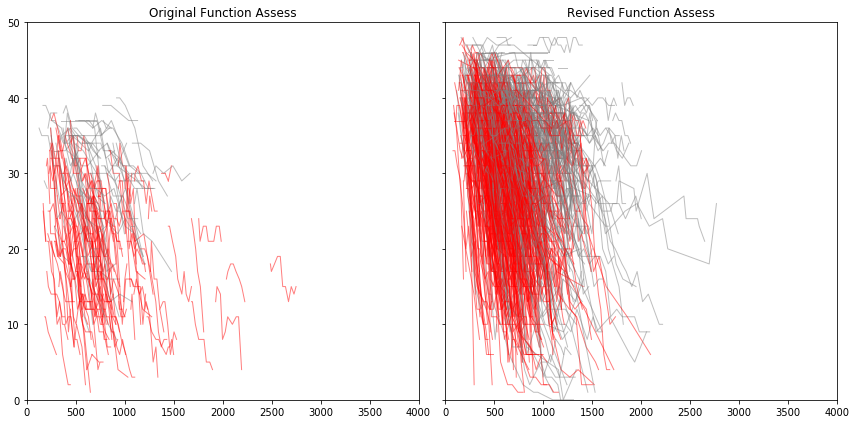

In [158]:
placebo = df[ df['Study_Arm'] == "Placebo"]
plot_question(placebo)

Notes on plots: many more subjects have the revised score. so many dead. seperate the deaths? length of survival? minimal score associated with death? how have some subjects have zero functionality and still alive? ANOVA? Is there a score level and below associated with death? 


## Progressor clusters

In [159]:
# perform cluster analysis on the subjects to find populations of 
# fast progressors, slow  progressors, and non-progressors.
from sklearn.cluster import KMeans

In [ ]:
km = KMeans(n_clusters=8, init=’k-means++’, n_init=10, max_iter=300, tol=0.0001, 
       precompute_distances=’auto’, verbose=0, random_state=None, copy_x=True, 
       n_jobs=None, algorithm=’auto’)

In [ ]:
# death within 1200 days of onset.
